%md
### 5. Análise de Marketing

**a. Análise de Conversão de Vendas:**  
Estudar a taxa de conversão de vendas com base em diferentes fontes de tráfego (orgânico, pago, social, etc.).



### Configuração do Ambiente e Carga de Dados

A primeira etapa consiste na preparação do ambiente de análise. O código a seguir importa as bibliotecas necessárias — **PySpark** para manipulação de dados e **Matplotlib/Seaborn** para visualização — e carrega os datasets do Unity Catalog para DataFrames Spark.

In [0]:
# Importa funções essenciais do PySpark
from pyspark.sql.functions import col, to_timestamp, datediff, avg, when, round, sum as _sum, countDistinct, year, month, quarter, count
from pyspark.sql import functions as F
from pyspark.sql import Row # Necessário para criar DataFrames a partir de listas de Rows

# Importa as bibliotecas de visualização
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors 

# Carrega cada tabela diretamente do seu catálogo e schema
# Certifique-se de que estas tabelas estão acessíveis no seu ambiente Databricks
customers_df = spark.table("workspace.default.olist_customers")
orders_df = spark.table("workspace.default.olist_orders")
order_items_df = spark.table("workspace.default.olist_order_items")
payments_df = spark.table("workspace.default.olist_order_payments")
reviews_df = spark.table("workspace.default.olist_order_reviews")
products_df = spark.table("workspace.default.olist_products")
sellers_df = spark.table("workspace.default.olist_sellers")
geolocation_df = spark.table("workspace.default.olist_geolocation")

print("Todos os datasets foram carregados com sucesso a partir do Unity Catalog.")

Todos os datasets foram carregados com sucesso a partir do Unity Catalog.


### Etapa 2: União e Filtragem Inicial dos DataFrames

Nesta fase, os DataFrames de **clientes** (`customers_df`), **pedidos** (`orders_df`) e **pagamentos** (`payments_df`) são unidos.  
A união é realizada para consolidar informações cruciais sobre as transações.

Adicionalmente:
- As colunas de data são convertidas para o tipo `timestamp`, permitindo operações temporais.
- Os dados são **filtrados** para incluir apenas os pedidos com status `"delivered"` (entregues),  
  criando um subconjunto focado na **análise de conversão**.


In [0]:
# Unir customers_df e orders_df
df_merged = orders_df.join(customers_df, on="customer_id", how="inner")

# Unir df_merged com payments_df
df_merged = df_merged.join(payments_df, on="order_id", how="inner")

# Filtrar para pedidos que foram realmente entregues para a análise de conversão
# Convertendo order_purchase_timestamp para timestamp para garantir operações de data
df_merged = df_merged.withColumn("order_purchase_timestamp", to_timestamp(col("order_purchase_timestamp")))
df_merged = df_merged.withColumn("order_delivered_customer_date", to_timestamp(col("order_delivered_customer_date")))

df_delivered = df_merged.filter(col("order_status") == "delivered")

print("DataFrames unidos e filtrados para pedidos entregues com sucesso.")
display(df_delivered.limit(5))

DataFrames unidos e filtrados para pedidos entregues com sucesso.


order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
00e7ee1b050b8499577073aeb2a297a1,06b8999e2fba1a1fbc88172c00ba8bc7,delivered,2017-05-16T15:05:35.000Z,2017-05-16T15:22:12.000Z,2017-05-23T10:47:57.000Z,2017-05-25T10:35:35.000Z,2017-06-05T00:00:00.000Z,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,1,credit_card,2,146.87
29150127e6685892b6eab3eec79f59c7,18955e83d337fd6b2def6b18a428ac77,delivered,2018-01-12T20:48:24.000Z,2018-01-12T20:58:32.000Z,2018-01-15T17:14:59.000Z,2018-01-29T12:41:19.000Z,2018-02-06T00:00:00.000Z,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,1,credit_card,8,335.48
b2059ed67ce144a36e2aa97d2c9e9ad2,4e7b3e00288586ebd08712fdd0374a03,delivered,2018-05-19T16:07:45.000Z,2018-05-20T16:19:10.000Z,2018-06-11T14:31:00.000Z,2018-06-14T17:58:51.000Z,2018-06-13T00:00:00.000Z,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,1,credit_card,7,157.73
951670f92359f4fe4a63112aa7306eba,b2b6027bc5c5109e529d4dc6358b12c3,delivered,2018-03-13T16:06:38.000Z,2018-03-13T17:29:19.000Z,2018-03-27T23:22:42.000Z,2018-03-28T16:04:25.000Z,2018-04-10T00:00:00.000Z,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,1,credit_card,1,173.3
6b7d50bd145f6fc7f33cebabd7e49d0f,4f2d8ab171c80ec8364f7c12e35b23ad,delivered,2018-07-29T09:51:30.000Z,2018-07-29T10:10:09.000Z,2018-07-30T15:16:00.000Z,2018-08-09T20:55:48.000Z,2018-08-15T00:00:00.000Z,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,1,credit_card,8,252.25


### Etapa 3: Cálculo da Taxa de Conversão por Estado

Esta etapa foca no **cálculo da taxa de conversão de vendas por estado do cliente**.

Passos executados:

- Contagem do **total de pedidos** e do **total de pedidos entregues** por estado.
- União dos resultados obtidos.
- Cálculo da **taxa de conversão**, definida como a porcentagem de pedidos entregues em relação ao total de pedidos.
- O valor da taxa é **arredondado para duas casas decimais**.
- Os dados finais são **ordenados de forma decrescente** com base no total de pedidos.


In [0]:
# Contar o total de pedidos por estado
total_orders_by_state = df_merged.groupBy("customer_state").agg(
    countDistinct("order_id").alias("total_orders")
)

# Contar o total de pedidos entregues por estado
delivered_orders_by_state = df_delivered.groupBy("customer_state").agg(
    countDistinct("order_id").alias("delivered_orders")
)

# Juntar os DataFrames e calcular a taxa de conversão
conversion_by_state = total_orders_by_state.join(delivered_orders_by_state, on="customer_state", how="left") \
    .fillna(0, subset=["delivered_orders"]) \
    .withColumn("conversion_rate", round((col("delivered_orders") / col("total_orders")) * 100, 2)) \
    .orderBy(col("total_orders").desc())

print("Taxa de conversão por estado calculada com sucesso.")
display(conversion_by_state)

Taxa de conversão por estado calculada com sucesso.


customer_state,total_orders,delivered_orders,conversion_rate
SP,41745,40500,97.02
RJ,12852,12350,96.09
MG,11635,11354,97.58
RS,5466,5345,97.79
PR,5045,4923,97.58
SC,3637,3546,97.5
BA,3380,3256,96.33
DF,2140,2080,97.2
ES,2033,1995,98.13
GO,2020,1957,96.88


### Etapa 4: Visualização da Taxa de Conversão por Estado

Esta seção é dedicada à **visualização da taxa de conversão dos 10 principais estados**.

Procedimentos realizados:

- Conversão dos dados de conversão por estado para um **DataFrame Pandas**, visando facilitar a criação da visualização.
- Criação de um **gráfico de barras** que representa a taxa de conversão em **porcentagem**.
- O eixo Y é configurado para variar de **80% a 100%**, proporcionando **maior foco nos detalhes** da variação.
- Inclusão de **rótulos de dados** diretamente nas barras para aumentar a clareza e facilitar a interpretação dos resultados.


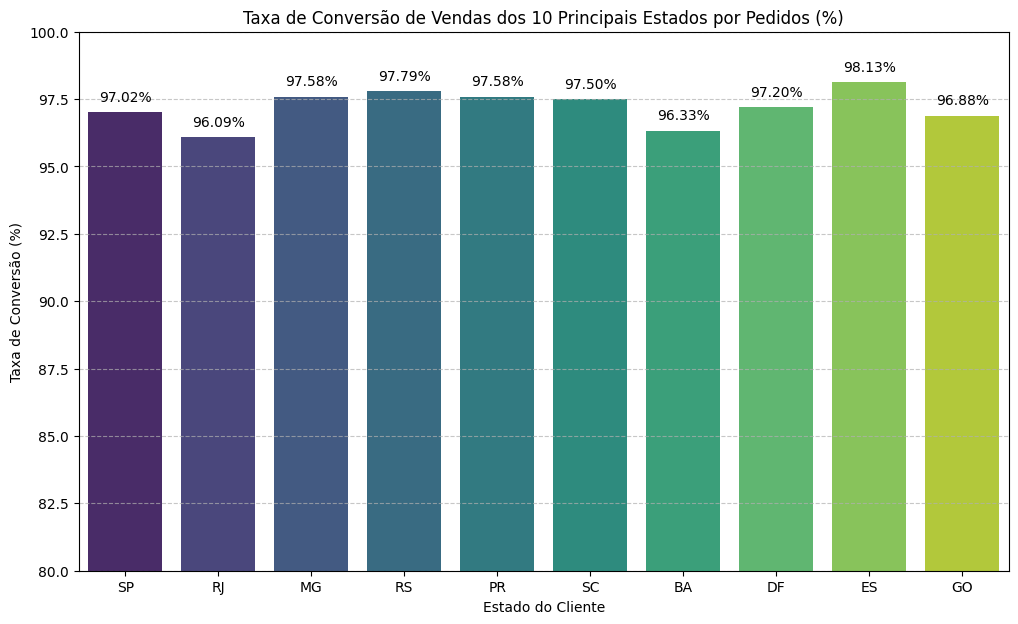

In [0]:
# Coletar os dados para visualização
conversion_by_state_pd = conversion_by_state.limit(10).toPandas()

# Gráfico 1: Taxa de Conversão de Vendas
plt.figure(figsize=(12, 7))
ax1 = sns.barplot(x="customer_state", y="conversion_rate", data=conversion_by_state_pd, palette="viridis")
plt.title("Taxa de Conversão de Vendas dos 10 Principais Estados por Pedidos (%)")
plt.xlabel("Estado do Cliente")
plt.ylabel("Taxa de Conversão (%)")
plt.ylim(80, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar rótulos nas barras
for i, row in conversion_by_state_pd.iterrows():
    ax1.text(i, row["conversion_rate"] + 0.3, f'{row["conversion_rate"]:.2f}%', ha='center', va='bottom', fontsize=10)

plt.show()


### Etapa 5: Visualização do Total de Pedidos por Estado

Complementando a análise anterior, esta etapa visualiza o **total de pedidos** para os **10 estados com maior volume**.

Procedimentos realizados:

- Utilização do mesmo **DataFrame Pandas (`conversion_by_state_pd`)** utilizado na etapa anterior.
- Geração de um **gráfico de barras** que exibe o número total de pedidos por estado.
- A visualização permite uma melhor **compreensão do volume de pedidos**, oferecendo **contexto adicional** para a interpretação das taxas de conversão.
- Inclusão de **rótulos de dados** com os valores exatos de pedidos para **facilitar a leitura e a análise comparativa**.


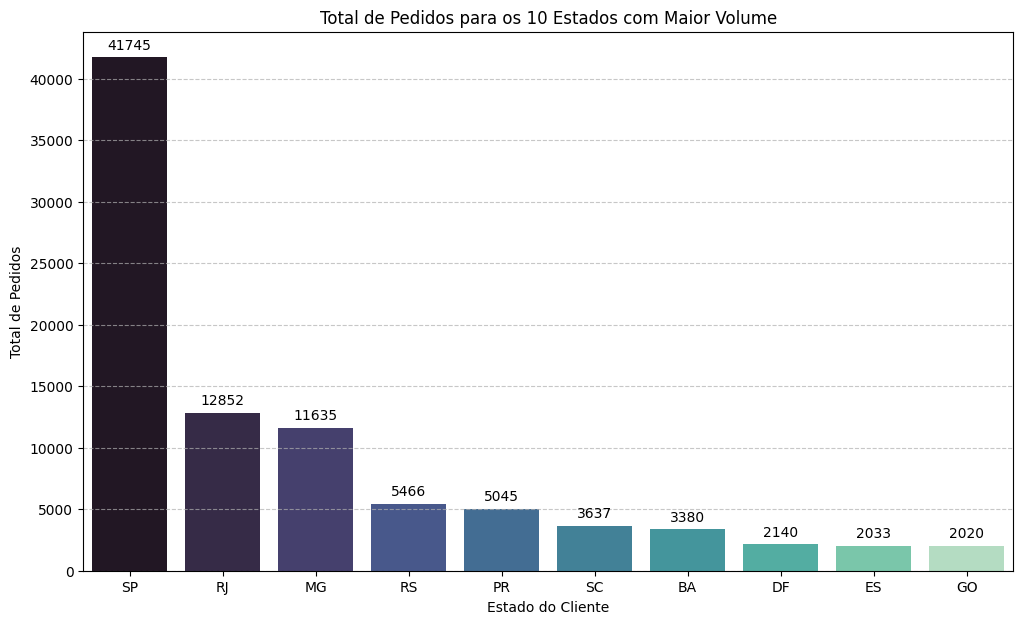

In [0]:
# Gráfico 2: Total de Pedidos
plt.figure(figsize=(12, 7))
ax2 = sns.barplot(x="customer_state", y="total_orders", data=conversion_by_state_pd, palette="mako")
plt.title("Total de Pedidos para os 10 Estados com Maior Volume")
plt.xlabel("Estado do Cliente")
plt.ylabel("Total de Pedidos")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar rótulos nas barras
for i, row in conversion_by_state_pd.iterrows():
    ax2.text(i, row["total_orders"] + max(conversion_by_state_pd["total_orders"]) * 0.01, 
             f'{int(row["total_orders"])}', ha='center', va='bottom', fontsize=10)

plt.show()

### Etapa 6: Cálculo da Taxa de Conversão por Tipo de Pagamento

Nesta etapa, o foco está na **análise da taxa de conversão por tipo de pagamento**.

Procedimentos realizados:

- Contagem do **total de pedidos** e do **total de pedidos entregues** para cada tipo de pagamento.
- União das duas contagens em um único DataFrame.
- Cálculo da **taxa de conversão**, com **arredondamento para duas casas decimais**.
- Ordenação dos resultados de forma **decrescente** com base no total de pedidos, facilitando a identificação dos métodos de pagamento mais utilizados.


In [0]:
# Contar o total de pedidos por tipo de pagamento
total_orders_by_payment_type = df_merged.groupBy("payment_type").agg(
    countDistinct("order_id").alias("total_orders")
)

# Contar o total de pedidos entregues por tipo de pagamento
delivered_orders_by_payment_type = df_delivered.groupBy("payment_type").agg(
    countDistinct("order_id").alias("delivered_orders")
)

# Juntar os DataFrames e calcular a taxa de conversão
conversion_by_payment_type = total_orders_by_payment_type.join(delivered_orders_by_payment_type, on="payment_type", how="left") \
    .fillna(0, subset=["delivered_orders"]) \
    .withColumn("conversion_rate", round((col("delivered_orders") / col("total_orders")) * 100, 2)) \
    .orderBy(col("total_orders").desc())

print("Taxa de conversão por tipo de pagamento calculada com sucesso.")
display(conversion_by_payment_type)

Taxa de conversão por tipo de pagamento calculada com sucesso.


payment_type,total_orders,delivered_orders,conversion_rate
credit_card,76505,74304,97.12
boleto,19784,19191,97.0
voucher,3866,3679,95.16
debit_card,1528,1485,97.19
not_defined,3,0,0.0


### Etapa 7: Re-união e Re-filtragem dos DataFrames (Opcional/Verificação)

Esta etapa repete as operações realizadas na **Etapa 2**, unindo novamente os DataFrames de **clientes**, **pedidos** e **pagamentos**.

Ações executadas:

- Conversão das colunas de **data** para o formato `timestamp`.
- Filtro para manter apenas os pedidos com status **"delivered"**.

**Observação:** Essa repetição pode servir como uma **verificação ou reinicialização** do ambiente, especialmente em casos de reexecução parcial do notebook. Contudo, em um fluxo de trabalho sequencial bem definido, essa etapa pode ser considerada **redundante**, caso os DataFrames já estejam no estado processado anteriormente.


In [0]:
# Unir customers_df e orders_df
df_merged = orders_df.join(customers_df, on="customer_id", how="inner")

# Unir df_merged com payments_df
df_merged = df_merged.join(payments_df, on="order_id", how="inner")

# Filtrar para pedidos que foram realmente entregues para a análise de conversão
# Convertendo order_purchase_timestamp para timestamp para garantir operações de data
df_merged = df_merged.withColumn("order_purchase_timestamp", to_timestamp(col("order_purchase_timestamp")))
df_merged = df_merged.withColumn("order_delivered_customer_date", to_timestamp(col("order_delivered_customer_date")))

df_delivered = df_merged.filter(col("order_status") == "delivered")

print("DataFrames unidos e filtrados para pedidos entregues com sucesso.")
display(df_delivered.limit(5))

DataFrames unidos e filtrados para pedidos entregues com sucesso.


order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
00e7ee1b050b8499577073aeb2a297a1,06b8999e2fba1a1fbc88172c00ba8bc7,delivered,2017-05-16T15:05:35.000Z,2017-05-16T15:22:12.000Z,2017-05-23T10:47:57.000Z,2017-05-25T10:35:35.000Z,2017-06-05T00:00:00.000Z,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,1,credit_card,2,146.87
29150127e6685892b6eab3eec79f59c7,18955e83d337fd6b2def6b18a428ac77,delivered,2018-01-12T20:48:24.000Z,2018-01-12T20:58:32.000Z,2018-01-15T17:14:59.000Z,2018-01-29T12:41:19.000Z,2018-02-06T00:00:00.000Z,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,1,credit_card,8,335.48
b2059ed67ce144a36e2aa97d2c9e9ad2,4e7b3e00288586ebd08712fdd0374a03,delivered,2018-05-19T16:07:45.000Z,2018-05-20T16:19:10.000Z,2018-06-11T14:31:00.000Z,2018-06-14T17:58:51.000Z,2018-06-13T00:00:00.000Z,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,1,credit_card,7,157.73
951670f92359f4fe4a63112aa7306eba,b2b6027bc5c5109e529d4dc6358b12c3,delivered,2018-03-13T16:06:38.000Z,2018-03-13T17:29:19.000Z,2018-03-27T23:22:42.000Z,2018-03-28T16:04:25.000Z,2018-04-10T00:00:00.000Z,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,1,credit_card,1,173.3
6b7d50bd145f6fc7f33cebabd7e49d0f,4f2d8ab171c80ec8364f7c12e35b23ad,delivered,2018-07-29T09:51:30.000Z,2018-07-29T10:10:09.000Z,2018-07-30T15:16:00.000Z,2018-08-09T20:55:48.000Z,2018-08-15T00:00:00.000Z,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,1,credit_card,8,252.25


### Etapa 8: Cálculo da Taxa de Conversão por Tipo de Pagamento (Excluindo 'not_defined')

Nesta etapa, é realizada uma **refinação da análise da taxa de conversão** por tipo de pagamento, com foco apenas nos métodos de pagamento válidos.

Ações executadas:

- **Filtragem** dos DataFrames `df_merged` e `df_delivered` para **excluir a categoria** onde `payment_type` é igual a `"not_defined"`.
- Contagem do **total de pedidos** e do **total de pedidos entregues** por tipo de pagamento.
- Cálculo da **taxa de conversão** para cada tipo, fornecendo uma visão mais limpa e precisa dos **métodos de pagamento relevantes**.
- Exibição dos resultados com os dados limpos, **reforçando a qualidade analítica da métrica**.

Essa abordagem evita distorções causadas por registros incompletos ou inválidos.


In [0]:
# Filtrar df_merged para remover 'not_defined' da coluna payment_type
df_merged_filtered_payment = df_merged.filter(col("payment_type") != "not_defined")

# Filtrar df_delivered para remover 'not_defined' da coluna payment_type
df_delivered_filtered_payment = df_delivered.filter(col("payment_type") != "not_defined")

# Contar o total de pedidos por tipo de pagamento (após filtragem)
total_orders_by_payment_type = df_merged_filtered_payment.groupBy("payment_type").agg(
    countDistinct("order_id").alias("total_orders")
)

# Contar o total de pedidos entregues por tipo de pagamento (após filtragem)
delivered_orders_by_payment_type = df_delivered_filtered_payment.groupBy("payment_type").agg(
    countDistinct("order_id").alias("delivered_orders")
)

# Juntar os DataFrames e calcular a taxa de conversão
conversion_by_payment_type = total_orders_by_payment_type.join(delivered_orders_by_payment_type, on="payment_type", how="left") \
    .fillna(0, subset=["delivered_orders"]) \
    .withColumn("conversion_rate", round((col("delivered_orders") / col("total_orders")) * 100, 2)) \
    .orderBy(col("total_orders").desc())

print("Taxa de conversão por tipo de pagamento calculada com sucesso, excluindo 'not_defined'.")
display(conversion_by_payment_type)

Taxa de conversão por tipo de pagamento calculada com sucesso, excluindo 'not_defined'.


payment_type,total_orders,delivered_orders,conversion_rate
credit_card,76505,74304,97.12
boleto,19784,19191,97.0
voucher,3866,3679,95.16
debit_card,1528,1485,97.19


### Etapa 9: Visualização da Taxa de Conversão por Tipo de Pagamento Válido

Esta etapa é dedicada à **visualização gráfica** da taxa de conversão para os **tipos de pagamento válidos**, ou seja, com a categoria `"not_defined"` previamente excluída.

Ações realizadas:

- Conversão do DataFrame de conversão para **formato Pandas**, permitindo o uso de bibliotecas de visualização.
- Criação de um **gráfico de barras** que mostra a **taxa de conversão (%)** por tipo de pagamento.
- O **eixo Y é ajustado** para a faixa de **80% a 100%**, proporcionando um foco detalhado nas variações de alta conversão.
- Inclusão de **rótulos de dados diretamente nas barras**, garantindo maior clareza na leitura dos valores.

Essa visualização facilita a identificação dos métodos de pagamento com melhor desempenho em termos de conversão.


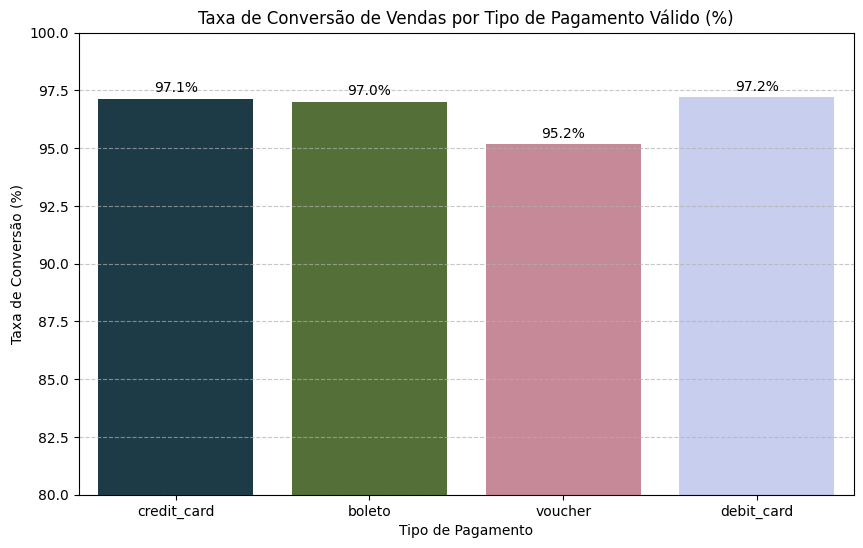

In [0]:
conversion_by_payment_type_pd = conversion_by_payment_type.toPandas()

plt.figure(figsize=(10, 6))
ax = sns.barplot(x="payment_type", y="conversion_rate", data=conversion_by_payment_type_pd, palette="cubehelix")
plt.title("Taxa de Conversão de Vendas por Tipo de Pagamento Válido (%)")
plt.xlabel("Tipo de Pagamento")
plt.ylabel("Taxa de Conversão (%)")
plt.ylim(80, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adiciona os valores acima das barras
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 0.3, f'{height:.1f}%', ha="center", fontsize=10)

plt.show()


### Etapa 10: Visualização do Total de Pedidos por Tipo de Pagamento Válido

Por fim, esta etapa tem como objetivo **visualizar o volume total de pedidos** para cada **tipo de pagamento válido**, com a categoria `"not_defined"` já excluída.

Ações realizadas:

- Geração de um **gráfico de barras** que mostra a **quantidade total de pedidos** por tipo de pagamento.
- Essa visualização revela a **frequência de uso** de cada método de pagamento pelos clientes.
- Os **rótulos de dados são incluídos nas barras**, indicando o número exato de pedidos por categoria.

Essa análise complementa a visualização da taxa de conversão, permitindo entender **não apenas o desempenho**, mas também a **popularidade de cada tipo de pagamento**.


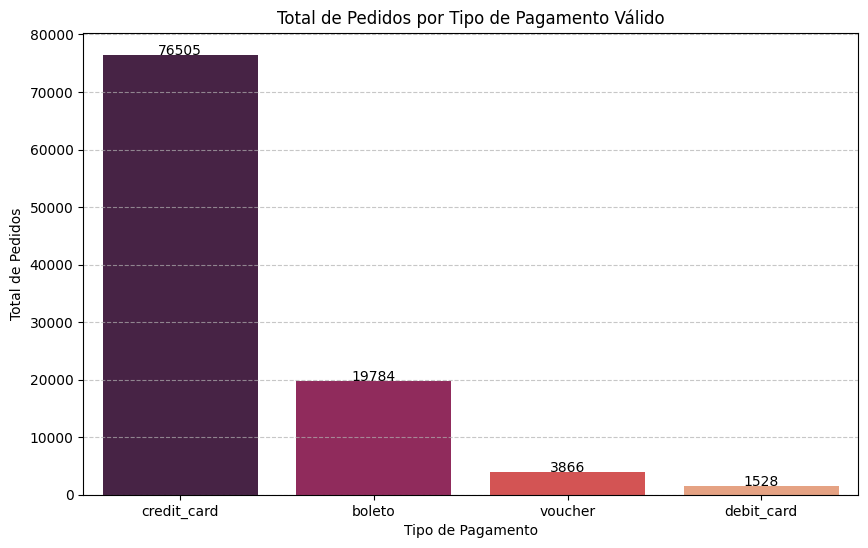

In [0]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="payment_type", y="total_orders", data=conversion_by_payment_type_pd, palette="rocket")
plt.title("Total de Pedidos por Tipo de Pagamento Válido")
plt.xlabel("Tipo de Pagamento")
plt.ylabel("Total de Pedidos")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adiciona os valores acima das barras
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, height + 50, f'{int(height)}', ha="center", fontsize=10)

plt.show()


### Conclusão dos Resultados da Análise de Conversão

---

#### Conversão por Estado do Cliente

A análise da taxa de conversão por estado:

- **Altas Taxas de Conversão Consistentes**:  
  De maneira geral, os 10 principais estados em volume de pedidos apresentam taxas de conversão **acima de 96%**, sugerindo uma **alta eficácia** na entrega e conclusão de pedidos para a maioria dos clientes no Brasil.

- **Destaque para São Paulo (SP)**:  
  São Paulo se destaca com o **maior volume de pedidos**, totalizando **41.745**, representando uma base de clientes significativamente maior.  
  Sua taxa de conversão de **97,02%** é robusta, indicando que, mesmo com grande volume, a operação de entrega permanece **eficiente**.

- **Estados com Ótima Performance de Conversão**:  
  **Espírito Santo (ES)** e **Acre (AC)** demonstraram as **mais altas taxas de conversão**, com **98,13%** e **98,77%**, respectivamente, ainda que com menor volume.  
  Isso pode indicar **logística mais otimizada** ou características demográficas favoráveis.

- **Variações Marginais**:  
  As taxas de conversão variam pouco entre os estados analisados (de **96,09%** a **98,13%**), sugerindo que a **qualidade do serviço de entrega** é relativamente homogênea nas regiões de maior demanda.

---

#### Conversão por Tipo de Pagamento

A análise da taxa de conversão por tipo de pagamento:

- **Domínio do Cartão de Crédito**:  
  Método mais utilizado, com **76.505 pedidos** (mais de 70% do total válido).  
  Apresenta uma taxa de conversão de **97,12%**, evidenciando sua **confiabilidade e preferência dos usuários**.

- **Boleto Bancário como Segunda Opção Forte**:  
  Segundo em volume, com **19.784 pedidos** e taxa de conversão de **97,0%**.  
  Mesmo com compensação mais lenta, mostra-se **altamente eficaz**.

- **Voucher com Menor Conversão**:  
  Menor taxa entre os métodos válidos, com **95,16%** em **3.866 pedidos**.  
  Pode indicar **desafios específicos**, como validade limitada ou restrições de uso.

- **Cartão de Débito com Ótima Conversão**:  
  Menor volume de pedidos (**1.528**), mas com **taxa de conversão de 97,19%**, a mais alta.  
  Indica **transações e entregas altamente eficientes** para quem opta por essa modalidade.
